# Download IMERG-Final data

In [1]:
import subprocess
import dask
from dask.distributed import Client, Semaphore
from pathlib import Path
import configparser
import os
import xarray as xr

In [2]:
client = Client(n_workers=os.cpu_count())
client

2023-04-25 22:43:36,011 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-worker-space-1006/worker-5g9xzyx9', purging
2023-04-25 22:43:36,011 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-worker-space-1006/worker-k96piby4', purging
2023-04-25 22:43:36,012 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-worker-space-1006/worker-xqx0bj9k', purging
2023-04-25 22:43:36,012 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-worker-space-1006/worker-nz3ogogp', purging
2023-04-25 22:43:36,012 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-worker-space-1006/worker-gpte9fvd', purging
2023-04-25 22:43:36,012 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-worker-space-1006/worker-z4v93mp7', purging
2023-04-25 22:43:36,013 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-worker-s

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 64
Total threads: 64,Total memory: 187.57 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:42721,Workers: 64
Dashboard: http://127.0.0.1:8787/status,Total threads: 64
Started: Just now,Total memory: 187.57 GiB
Comm: tcp://127.0.0.1:36671,Total threads: 1
Dashboard: http://127.0.0.1:45829/status,Memory: 2.93 GiB
Nanny: tcp://127.0.0.1:35167,


In [8]:
secrets = configparser.ConfigParser()
secrets.read('../../secrets/secrets.ini')

['../../secrets/secrets.ini']

In [15]:
download_list_fn = Path("../../data-precip-analysis/imerg_final_download_list.txt")
download_dir = download_list_fn.parent
download_list = download_list_fn.read_text().split('\n')

sem = Semaphore(max_leases=8)

def download_imerg_final_url(url, sem):
    name = url.split('/')[-1].split('?')[0]
    fp = download_dir / name
    result = None
    if not fp.exists():
        with sem:
            result = subprocess.run(['wget', f'--user={secrets["earthdata"]["username"]}', f'--password={secrets["earthdata"]["password"]}', '--no-clobber', '-O', download_dir / name, url], capture_output=True)
    
    return result

futures = []
for url in download_list:
    future = dask.delayed(download_imerg_final_url)(url, sem)
    futures.append(future)

futures

[Delayed('download_imerg_final_url-b99f8134-04e1-4393-9624-578975a839ae'),
 Delayed('download_imerg_final_url-0d4e9ffd-94d4-4743-a335-b45b0b9236a6'),
 Delayed('download_imerg_final_url-4fc1b20e-9dd7-4122-9839-5ae0132da93c'),
 Delayed('download_imerg_final_url-a46a6a5f-3a45-4fd7-9909-053154e90243'),
 Delayed('download_imerg_final_url-5daf39dd-daef-4f5e-8b09-ce22abbf211f'),
 Delayed('download_imerg_final_url-79a70321-b342-4837-9743-34fd2b3514a5'),
 Delayed('download_imerg_final_url-f43bf58c-354c-463c-bcef-87ac8674e804'),
 Delayed('download_imerg_final_url-69af5136-3f5c-461f-8234-67b9a66a928a'),
 Delayed('download_imerg_final_url-af122cba-659a-4706-9c88-91e6f020be31'),
 Delayed('download_imerg_final_url-5c19f25e-25f3-4ef7-bbe1-fd54b1de4c69'),
 Delayed('download_imerg_final_url-aa8ff815-9434-41e5-8520-586d4f5c5e52'),
 Delayed('download_imerg_final_url-f85ee8bd-a18d-456d-805b-2f1a3323b390'),
 Delayed('download_imerg_final_url-71ee8ef6-2054-46a4-b63b-a57544aaca0a'),
 Delayed('download_imerg_

In [16]:
results = dask.compute(*futures)

In [3]:
# inspect downloaded file
fn = Path(f"../../data-precip-analysis")

dses = []

@dask.delayed
def load(fn):
    try:
        ds = xr.open_mfdataset(fn)
        return ds
    except:
        fn.unlink()
        return None

dses = [load(f) for f in fn.glob("3B-DAY.MS.MRG.3IMERG.*.nc4")]

# combined = dask.delayed(xr.merge)(dses)
# combined

ds = xr.open_mfdataset(fn.glob("3B-DAY.MS.MRG.3IMERG.*.nc4"), parallel=True, engine='h5netcdf')
ds

<xarray.Dataset>
Dimensions:                    (time: 6744, lon: 683, lat: 311, nv: 2)
Coordinates:
  * lat                        (lat) float32 22.55 22.65 22.75 ... 53.45 53.55
  * lon                        (lon) float32 -126.5 -126.4 ... -58.45 -58.35
  * nv                         (nv) float32 0.0 1.0
  * time                       (time) object 2000-06-01 00:00:00 ... 2021-09-...
Data variables:
    precipitationCal           (time, lon, lat) float32 dask.array<chunksize=(1, 683, 311), meta=np.ndarray>
    HQprecipitation            (time, lon, lat) float32 dask.array<chunksize=(1, 683, 311), meta=np.ndarray>
    precipitationCal_cnt       (time, lon, lat) int16 dask.array<chunksize=(1, 683, 311), meta=np.ndarray>
    randomError                (time, lon, lat) float32 dask.array<chunksize=(1, 683, 311), meta=np.ndarray>
    randomError_cnt            (time, lon, lat) int16 dask.array<chunksize=(1, 683, 311), meta=np.ndarray>
    time_bnds                  (time, nv) object dask.array<chunksize=(1, 2), meta=np.ndarray>
    precipitationCal_cnt_cond  (time, lon, lat) int16 dask.array<chunksize=(1, 683, 311), meta=np.ndarray>
    HQprecipitation_cnt        (time, lon, lat) int16 dask.array<chunksize=(1, 683, 311), meta=np.ndarray>
    HQprecipitation_cnt_cond   (time, lon, lat) int16 dask.array<chunksize=(1, 683, 311), meta=np.ndarray>
Attributes:
    BeginDate:       2000-06-01
    BeginTime:       00:00:00.000Z
    EndDate:         2000-06-01
    EndTime:         23:59:59.999Z
    FileHeader:      StartGranuleDateTime=2000-06-01T00:00:00.000Z;\nStopGran...
    InputPointer:    3B-HHR.MS.MRG.3IMERG.20000601-S000000-E002959.0000.V06B....
    title:           GPM IMERG Final Precipitation L3 1 day 0.1 degree x 0.1 ...
    DOI:             10.5067/GPM/IMERGDF/DAY/06
    ProductionTime:  2019-06-18T20:51:50.167Z
    history:         2023-04-26 05:18:28 GMT Hyrax-1.16.3 https://gpm1.gesdis...

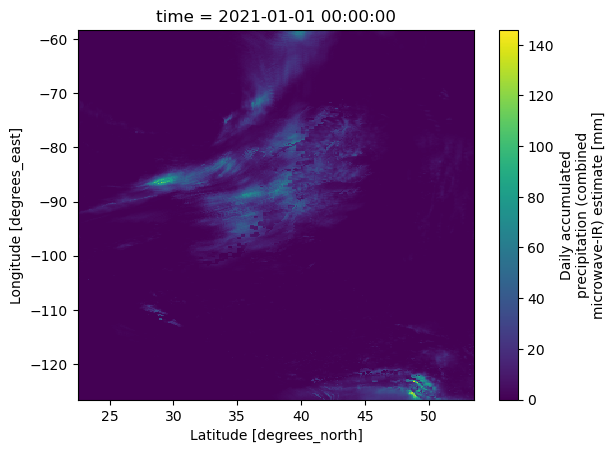

In [10]:
ds['precipitationCal'].sel(time='2021-01-01').plot()

In [5]:
ds.load()

/water2/pdas47/2023_01_24-river-regulation/.env/lib/python3.10/site-packages/distributed/client.py:3095: UserWarning: Sending large graph of size 36.99 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


<xarray.Dataset>
Dimensions:                    (time: 6744, lon: 683, lat: 311, nv: 2)
Coordinates:
  * lat                        (lat) float32 22.55 22.65 22.75 ... 53.45 53.55
  * lon                        (lon) float32 -126.5 -126.4 ... -58.45 -58.35
  * nv                         (nv) float32 0.0 1.0
  * time                       (time) object 2000-06-01 00:00:00 ... 2021-09-...
Data variables:
    precipitationCal           (time, lon, lat) float32 0.0 0.0 ... 3.822 2.659
    HQprecipitation            (time, lon, lat) float32 0.0 0.0 ... 1.83 1.59
    precipitationCal_cnt       (time, lon, lat) int16 48 48 48 48 ... 48 48 48
    randomError                (time, lon, lat) float32 0.8249 0.8249 ... 5.694
    randomError_cnt            (time, lon, lat) int16 48 48 48 48 ... 48 48 48
    time_bnds                  (time, nv) object 2000-06-01 00:00:00 ... 2021...
    precipitationCal_cnt_cond  (time, lon, lat) int16 0 0 0 0 0 ... 13 12 12 10
    HQprecipitation_cnt        (time, lon, lat) int16 8 8 8 8 8 ... 17 17 17 17
    HQprecipitation_cnt_cond   (time, lon, lat) int16 0 0 0 0 0 0 ... 4 4 4 4 4
Attributes:
    BeginDate:       2000-06-01
    BeginTime:       00:00:00.000Z
    EndDate:         2000-06-01
    EndTime:         23:59:59.999Z
    FileHeader:      StartGranuleDateTime=2000-06-01T00:00:00.000Z;\nStopGran...
    InputPointer:    3B-HHR.MS.MRG.3IMERG.20000601-S000000-E002959.0000.V06B....
    title:           GPM IMERG Final Precipitation L3 1 day 0.1 degree x 0.1 ...
    DOI:             10.5067/GPM/IMERGDF/DAY/06
    ProductionTime:  2019-06-18T20:51:50.167Z
    history:         2023-04-26 05:18:28 GMT Hyrax-1.16.3 https://gpm1.gesdis...

In [6]:
ds.to_netcdf('../../data-precip-analysis/imerg_final/imerg_final.nc', engine='h5netcdf')